# Grid Proposals

## Vector Grids

In [11]:
#nbx --fname=../../src/grid_proposals.jl

using BenchmarkTools
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings

push!(LOAD_PATH, "../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [6]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int.(floor.((x .+ r./2 .- zero)./r))

quantize

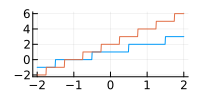

In [7]:
xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

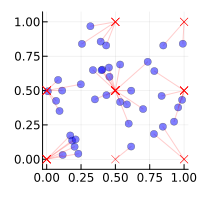

In [8]:
r  = [0.5, 0.5]
xs = unstack(rand(40,2))
is = quantize.(xs, [r])
# ------------------------
mypl = plot(size=(200,200), aspect_ratio=:equal, legend=nothing)
for (x,i) in zip(xs, is)
    y = i.*r
    plot!([x,y], c=:red, alpha=0.2)
    scatter!([x], c=:blue, alpha=0.5)
    scatter!([y], c=:red, marker=:x)
    
end
mypl

**Vector Grids.** In our contrect a vector grid is defined by a triple `(v0,k,r)`, where
-  `v0` is a vector defining the center of the grid,
-  `k` is a integer vector that contains the number of grid points in each dimension, and
-  `r` is a float vector that contains the resolution along each dimension.

In [9]:
#nbx
"""
    get_offset(v0, k, r)

Computes the offset to move the center 
of the grid to `v0`.
"""
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end

function first_grid_vec(v0::Vector{Real}, k::Vector{Int}, r::Vector{Real})
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    ls = LinearIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return (vs=vs, linear_indices=ls)
end


function grid_index(x, v0, k, r; linear=false)
    I = quantize(x, r, zero=get_offset(v0, k, r));
    if linear
        shape = Tuple(k)
        I = LinearIndices(shape)[I...] 
    end
    return I
end

grid_index (generic function with 1 method)

In [12]:
v0 = rand(4)
k  = [10,10,10,10]
r  = [0.5,0.5,0.5,0.5]

x = rand(4)

@btime vector_grid(v0, k, r);
@btime grid_index(x, v0, k, r; linear=false);
@btime grid_index(x, v0, k, r; linear=true);

  1.399 ms (30016 allocations: 2.82 MiB)
  309.183 ns (5 allocations: 480 bytes)
  906.238 ns (10 allocations: 688 bytes)


## Eval Poses

In [13]:
#nbx
"""
    log_ps, ps = eval_pose_vectors(
                    vs   :: Array{Vector{Float64}},
                    z    :: Vector{Float64}, 
                    segs :: Vector{Segment}, 
                    fov, num_a, 
                    w::Int, sig, outlier, zmax::Float64=50.0; 
                    sorted = false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            vs   :: Array{Vector{Float64}},
            z    :: Vector{Float64}, 
            segs :: Vector{Segment}, 
            fov, num_a, w::Int, 
            sig, outlier, 
            zmax::Float64=50.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps   = stack(vs[:])
    segs = stack(Vector.(segs))
    as   = create_angles(fov, num_a)

    if _cuda[]
        ps   = CuArray(ps)
        z    = CuArray(z)
        segs = CuArray(segs)
        as   = CuArray(as)
    end
    

    
    zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    ỹ, d̃ = get_1d_mixture_components(zs, as, w);
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_p, = depthdist_logpdf(zs, ỹ, d̃, sig, outlier, zmax; 
                              scale_noise=false, return_pointwise=false, return_outliermap=false);
    
    # Move everyting back to CPU if is not already there
    log_ps = Array(log_ps)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        vs     = vs[:][perm]
    end
    
    return log_ps, vs[:]
end;

